In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(1)

In [2]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

In [3]:
x_train, y_train = load_CIFAR_batch('cifar-10/data_batch_1')

In [4]:
x_test, y_test = load_CIFAR_batch('cifar-10/data_batch_3')

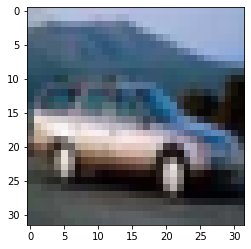

In [5]:
plt.imshow(x_train[4].astype('int'));

In [6]:
class Linear():
    
    def __init__(self, in_features, out_features):
        
        # define weights
        self.w = np.random.randn(in_features, out_features)*0.01
        self.b = np.zeros(out_features)
        
        # define cache and grads
        self.inputs = None
        self.dw = None
        self.db = None
        
    def forward(self, x):
        # save inputs for backward pass
        self.inputs = x
        return x.dot(self.w) + self.b[np.newaxis, :]
    
    def backward(self, dout):
        
        assert self.inputs is not None, 'Use backward after forward'
        N = dout.shape[0]
        dinputs = dout.dot(self.w.T).reshape(self.inputs.shape)
        self.dw = self.inputs.reshape(N, -1).T.dot(dout)
        self.db = dout.sum(axis = 0)
        
        # reset cache: inputs -> None
        self.inputs = None
        return dinputs

    def step(self, lr=0.01):
        assert self.dw is not None, 'Update weights only after backward'
        self.w -= lr*self.dw
        self.b -= lr*self.db
        
        # reset gradients: dw, db -> None
        self.dw = None
        self.db = None

In [7]:
class ReLU():
    
    def __init__(self):

        # define cache
        self.inputs = None

    def forward(self, x):
        # save inputs for backward pass
        self.inputs = x
        return np.maximum(x, 0)
    
    def backward(self, dout):
        
        assert self.inputs is not None, 'Use backward after forward'
        dinputs = dout * np.greater(self.inputs, 0).astype('int64')
        
        # reset cache: inputs -> None
        self.inputs = None
        return dinputs

    def step(self, lr=0.01):
        pass
    
class Sigmoid():

    def forward(self, x):
        return 1/(1+np.exp(-x))
    
    def backward(self, dout): 
        return np.exp(-dout)/((1+np.exp(-dout))**2)

    def step(self, lr=0.01):
        pass

In [8]:
def one_hot(y, classes=10):
    y_bin = np.zeros((y.shape[0], classes))
    y_bin[np.arange(len(y)), y] +=1
    return y_bin

def logist_loss(x, y):
    dout = x - y
    loss = dout.sum(axis=1).mean()
    return loss, dout

def softmax_loss(X, y):

    scores = np.exp(X)
    scores = scores/scores.sum(axis = 1, keepdims=True)
    loss = -(np.log(scores) * y).sum(axis = 1).mean()
    dout = scores - y
    return loss, dout

In [9]:
class NeuralNet():
    def __init__(self, in_features, hiddens, classes=10):
        
        self.classes = classes
        self.layers = []

        for hidden in hiddens:
            self.layers.append(Linear(in_features, hidden))
            self.layers.append(ReLU())
            in_features = hidden
            
        self.layers.append(Linear(in_features, classes))
#         self.layers.append(Sigmoid())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
            
    def step(self, lr=1e-7):
        for layer in self.layers:
            dout = layer.step(lr)
    
    def fit(self, X, y, epoches, log_step = 100, lr=1e-7):
        X = X.reshape(X.shape[0], -1)
        y = one_hot(y, self.classes)
        for e in range(epoches):
            score = self.forward(X)
            loss, dout = softmax_loss(score, y)
            if e % log_step == 0:
                print('Loss: ', loss)
            self.backward(dout)
            self.step(lr)
            
    def predict(self, X):
        X = X.reshape(X.shape[0], -1)
        return np.argmax(self.forward(X), 1)

In [10]:
m = NeuralNet(32*32*3, [32, 16])

In [11]:
m.fit(x_train, y_train, 1000, lr=1e-7)

Loss:  2.3000670974743413
Loss:  2.223920651806414
Loss:  2.0646061224477728
Loss:  2.0141965217598625
Loss:  1.9630135635225947
Loss:  1.917406357854835
Loss:  1.8873606937286327
Loss:  1.8613881321231887
Loss:  1.8349452071206396
Loss:  1.8142299324507913


In [12]:
y_test_pred = m.predict(x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

Softmax on raw pixels final test set accuracy: 0.348300
